# Solve Racetrack using off-policy MC control

In [1]:
from racetrack.env import RacetrackEnv
from racetrack.tracks import track_test, track1, track2

from copy import deepcopy
import numpy as np
import random
from tqdm import tqdm


track = deepcopy(track2)
env = RacetrackEnv(track)
test_env = RacetrackEnv(track)

In [2]:
obs_shape = env.observation_space.nvec
obs_num = np.product(obs_shape)

act_shape = env.action_space.nvec
act_num = np.product(act_shape)
all_actions = [(i, j) for i in range(act_shape[0]) for j in range(act_shape[1])]
action_id = dict(zip(all_actions, np.arange(act_num)))
id_action = dict(zip(np.arange(act_num), all_actions))

In [3]:
def random_policy(obs):
    return random.choice(list(action_id.keys()))

def eps_greedy_policy(obs, eps=0.3):
    if np.random.random() < eps:
        return random.choice(list(action_id.keys()))
    else:
        act_id = np.argmax(q_value, axis=-1)[tuple(obs)]
        act = id_action[act_id]
        return act

def target_policy(q_value):
    policy = np.argmax(q_value, axis=-1)
    def _policy(obs):
        act_id = policy[tuple(obs)]
        act = id_action[act_id]
        return act
    return _policy

def generate_episode(env, policy):
    episode = []
    obs = env.reset()
    while True:
        act = policy(obs)
        next_obs, reward, done, _ = env.step(act)
        episode.append([obs, act, reward])
        if done:
            break
        else:
            obs = next_obs
    return episode

In [4]:
gamma = 0.99
episode_num = int(1e5)

q_value = np.random.random(size=tuple(env.observation_space.nvec) + (act_num, ))
sa_weight = np.zeros(shape=tuple(env.observation_space.nvec) + (act_num, ))
for i in tqdm(range(episode_num)):
    behavior_policy = random_policy
    episode = generate_episode(env, behavior_policy)
    
    gain = 0
    weight = 1
    for obs, act, reward in reversed(episode):
        gain = gamma * gain + reward
        sa_weight[tuple(obs)][action_id[act]] = sa_weight[tuple(obs)][action_id[act]] + weight
        
        q = q_value[tuple(obs)][action_id[act]]
        q_value[tuple(obs)][action_id[act]] = q + (weight / sa_weight[tuple(obs)][action_id[act]]) * (gain - q)
        
        pi_act = id_action[np.argmax(q_value[tuple(obs)])]
        if pi_act != act:
            break
        else:
            b_prob = 1 / 9  # the value is 0.7 + eps / 9 if use `eps_greedy_policy`
            weight = weight / b_prob

100%|██████████| 100000/100000 [10:29<00:00, 158.82it/s]


### Visualizing one solution

In [26]:
policy = target_policy(q_value)
episode = []
track = deepcopy(track2)
obs = test_env.reset()
for i in range(int(1e4)):
    act = policy(obs)
    next_obs, reward, done, _ = test_env.step(act)
    episode.append([obs, act, reward])
    if done:
        break
    else:
        obs = next_obs
            
traj = [step[0][:2] for step in episode]

In [27]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import animation

def _animate(i):
    x, y = traj[i]
    track[x, y] = 4
    img.set_data(track)
    return img

def _init():
    img.set_data(track)
    return img

Traceback (most recent call last):
  File "/home/zheyue/miniconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/home/zheyue/miniconda3/lib/python3.8/site-packages/matplotlib/animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


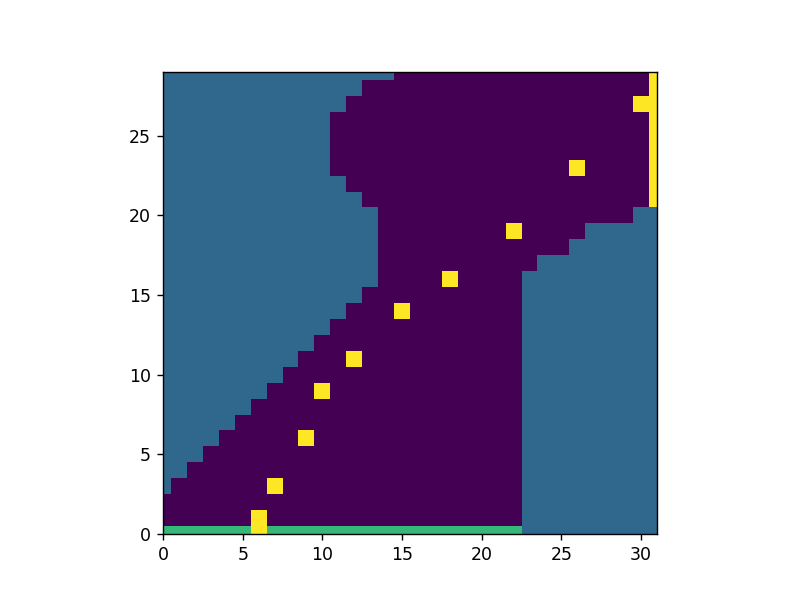

In [28]:
fig, ax = plt.subplots()
plt.ylim(0, track.shape[0] - 1)
plt.xlim(0, track.shape[1] - 1)
img = ax.imshow(track)
ani = animation.FuncAnimation(fig=fig,
                              func=_animate,
                              frames=len(traj),
                              init_func=_init,
                              interval=80,
                              blit=False)

plt.show()

Just one suboptimal solution is demonstrated here, better performance can be achived be training on more episodes or using another behavior policy (a uni-random policy was used).